In [22]:
from PIL import Image
import random
import math

def generate_voronoi_diagram(width, height, num_cells):
    image = Image.new("RGB", (width, height))
    putpixel = image.putpixel
    imgx, imgy = image.size
    nx = []
    ny = []
    nr = []
    ng = []
    nb = []
    for i in range(num_cells):
        nx.append(random.randrange(imgx))
        ny.append(random.randrange(imgy))
        nr.append(random.randrange(256))
        ng.append(random.randrange(256))
        nb.append(random.randrange(256))
    for y in range(imgy):
        for x in range(imgx):
            dmin = math.hypot(imgx-1, imgy-1)
            j = -1
            for i in range(num_cells):
                d = math.hypot(nx[i]-x, ny[i]-y)
                if d < dmin:
                    dmin = d
                    j = i
            putpixel((x, y), (nr[j], ng[j], nb[j]))
    image.save("VoronoiDiagram.png", "PNG")
    image.show()

generate_voronoi_diagram(500, 500, 25)

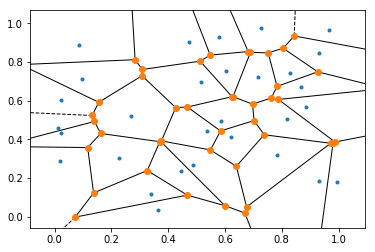

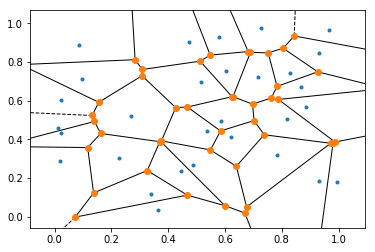

In [21]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely.geometry
import shapely.ops

points = np.random.random((30, 2))
vor = Voronoi(points)
voronoi_plot_2d(vor)

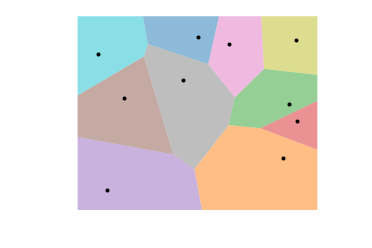

In [48]:
# https://gist.github.com/pv/8036995

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        if p1 in all_ridges:
            ridges = all_ridges[p1]
            new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(1386)
points = np.random.rand(10, 2)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = vor.min_bound[0] - 0.1
max_x = vor.max_bound[0] + 0.1
min_y = vor.min_bound[1] - 0.1
max_y = vor.max_bound[1] + 0.1

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)



box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    
    plt.fill_between(*zip(*polygon), alpha=0.5)

    #plt.fill(*zip(*polygon), alpha=0.5)

plt.plot(points[:, 0], points[:, 1], 'ko', markersize=3)
plt.axis('equal')
#plt.xlim(vor.min_bound[0], vor.max_bound[0])
#plt.ylim(vor.min_bound[1], vor.max_bound[1])
plt.axis('off')

plt.savefig('voro.png')
plt.show()